#  Q-Learning on Non-Slippery FrozenLake
**Algorithm:** Q-Learning with Epsilon-Greedy exploration  
**Environment:** `FrozenLake-v1` (non-slippery) via [Gymnasium](https://gymnasium.farama.org/environments/toy_text/frozen_lake/#frozen-lake)  
**Goal:** Train an agent to navigate from start (S) to goal (G) avoiding holes (H) in the minimum number of steps.

## Install & Import

In [2]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt

## The Frozen Lake Environment

The grid is 4×4 = **16 states**. Each tile is one of:
- `S` — Starting point (safe)
- `F` — Frozen surface (safe)
- `H` — Hole (episode ends, reward = 0)
- `G` — Goal (reward = 1)

The agent has **4 actions**: LEFT=0, DOWN=1, RIGHT=2, UP=3  
We use `is_slippery=False` so actions are deterministic.

## Q-Learning Training Loop (Written From Scratch)

### The Q-Learning Update Formula

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \cdot \left[ r_t + \gamma \cdot \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right]$$

| Symbol | Meaning | Value Used |
|--------|---------|------------|
| $\alpha$ | Learning rate | 0.2 |
| $\gamma$ | Discount factor | 0.99 |
| $\epsilon$ | Exploration rate | 1.0 → 0.01 |
| $\epsilon_{decay}$ | Decay per episode | 0.999 |

### Epsilon-Greedy Strategy
- With probability $\epsilon$ → **explore** (random action)
- With probability $1-\epsilon$ → **exploit** (best known action)
- $\epsilon$ decays each episode: agent explores less as it learns more

In [3]:
def train_agent(alpha=0.5, gamma=0.9, episodes=1000,
                epsilon=1.0, epsilon_decay=0.001, is_slippery=False):
    
    env = gym.make("FrozenLake-v1", is_slippery=is_slippery)
    nb_states  = env.observation_space.n
    nb_actions = env.action_space.n
    qtable     = np.zeros((nb_states, nb_actions))
    ep_rewards = []

    for _ in range(episodes):
        state, _ = env.reset()
        done  = False
        total_reward = 0

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable[state])

            new_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            qtable[state, action] += alpha * (
                reward + gamma * np.max(qtable[new_state]) - qtable[state, action]
            )

            state = new_state
            total_reward += reward

        ep_rewards.append(total_reward)
        epsilon = max(epsilon - epsilon_decay, 0.01)

    env.close()
    return qtable, ep_rewards

##  Evaluation & Random Policy Functions

**Evaluation** uses pure greedy policy (no exploration, Q-table frozen) to measure true learned performance.  
**Random policy** serves as the lower bound baseline the task requires us to beat.

In [14]:
def evaluate_agent(qtable, eval_episodes=100):
    env = gym.make("FrozenLake-v1", is_slippery=False)
    nb_success = 0
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(qtable[state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            nb_success += reward
    env.close()
    return nb_success / eval_episodes * 100


def random_policy(eval_episodes=100):
   
    env = gym.make("FrozenLake-v1", is_slippery=False)   
    nb_success = 0
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            nb_success += reward
    env.close()
    return nb_success / eval_episodes * 100


def rolling_avg(data, window):
    return np.convolve(data, np.ones(window) / window, mode='valid')

##  Train the Baseline Agent

**Hyperparameters:**
Hyperparameters:
alpha = 0.5 → Learning rate
gamma = 0.9 → Discount factor
epsilon = 1.0 → 0.0 → Exploration rate (linear decay)
episodes = 1000 → Total training episodes

In [15]:
EPISODES      = 1000
ROLLING_WIN   = 50
EVAL_EPISODES = 100

print("Training baseline agent (alpha=0.5, gamma=0.9) ...")
qtable_base, rewards_base = train_agent(alpha=0.5, gamma=0.9, episodes=EPISODES)

agent_avg  = evaluate_agent(qtable_base, EVAL_EPISODES)
random_avg = random_policy(EVAL_EPISODES)

print(f"Baseline agent  avg reward over 100 test episodes: {agent_avg:.1f}%")
print(f"Random policy   avg reward over 100 test episodes: {random_avg:.1f}%")

Training baseline agent (alpha=0.5, gamma=0.9) ...
Baseline agent  avg reward over 100 test episodes: 100.0%
Random policy   avg reward over 100 test episodes: 1.0%


## Result 1 (Reward Curve)
Episode reward smoothed with a rolling average (window = 50).  
The dashed red line shows the random policy baseline for comparison.

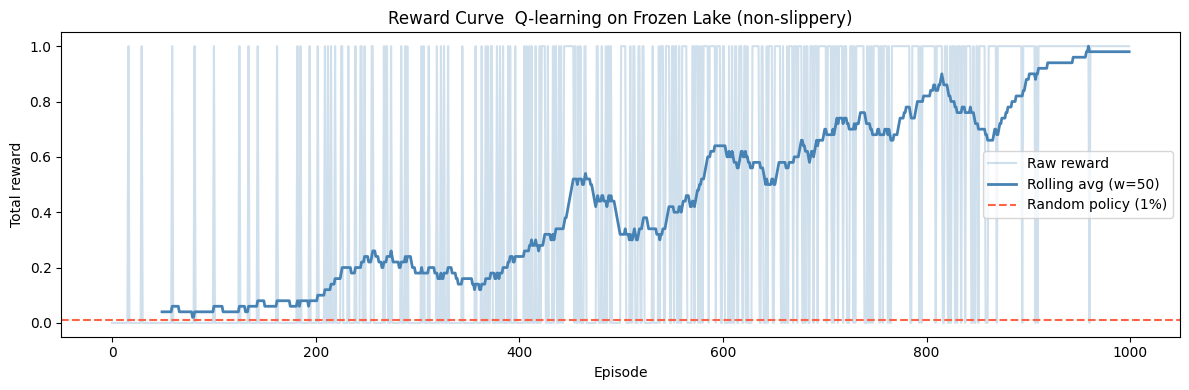

In [16]:
smoothed = rolling_avg(rewards_base, ROLLING_WIN)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(rewards_base)), rewards_base,
        alpha=0.25, color="steelblue", label="Raw reward")
ax.plot(range(ROLLING_WIN - 1, len(rewards_base)), smoothed,
        color="steelblue", linewidth=2, label=f"Rolling avg (w={ROLLING_WIN})")
ax.axhline(random_avg / 100, color="tomato", linestyle="--", linewidth=1.5,
           label=f"Random policy ({random_avg:.0f}%)")
ax.set_xlabel("Episode")
ax.set_ylabel("Total reward")
ax.set_title("Reward Curve  Q-learning on Frozen Lake (non-slippery)")
ax.legend()
plt.tight_layout()
plt.savefig("reward_curve.png", dpi=150)
plt.show()

## Result 2 (Hyperparameter Experiments)

We sweep **alpha** (learning rate) and **gamma** (discount factor) independently  
to see how each one affects convergence speed and final performance.

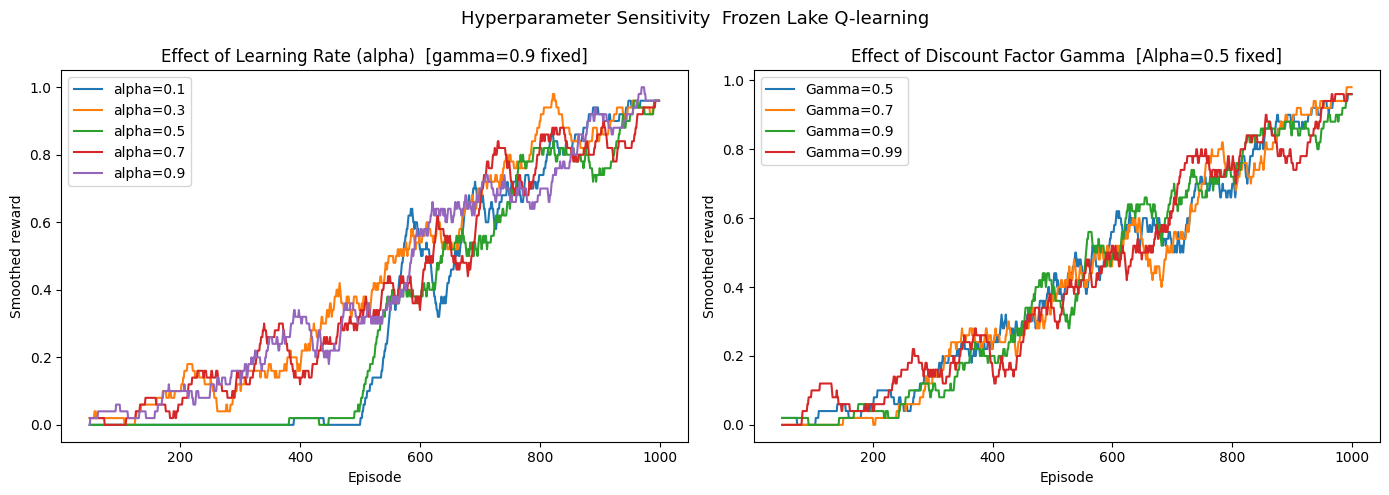

In [17]:
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma_values = [0.5, 0.7, 0.9, 0.99]

alpha_curves = {}
for a in alpha_values:
    _, rews = train_agent(alpha=a, gamma=0.9, episodes=EPISODES)
    alpha_curves[a] = rolling_avg(rews, ROLLING_WIN)

gamma_curves = {}
for g in gamma_values:
    _, rews = train_agent(alpha=0.5, gamma=g, episodes=EPISODES)
    gamma_curves[g] = rolling_avg(rews, ROLLING_WIN)

x = range(ROLLING_WIN - 1, EPISODES)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for a, curve in alpha_curves.items():
    axes[0].plot(x, curve, label=f"alpha={a}")
axes[0].set_title("Effect of Learning Rate (alpha)  [gamma=0.9 fixed]")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Smoothed reward")
axes[0].legend()

for g, curve in gamma_curves.items():
    axes[1].plot(x, curve, label=f"Gamma={g}")
axes[1].set_title("Effect of Discount Factor Gamma  [Alpha=0.5 fixed]")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Smoothed reward")
axes[1].legend()

plt.suptitle("Hyperparameter Sensitivity  Frozen Lake Q-learning", fontsize=13)
plt.tight_layout()
plt.savefig("hyperparameter_experiments.png", dpi=150)
plt.show()

##  Q-Table

In [18]:
print("Q-table:")
print(qtable_base)

Q-table:
[[0.531441   0.59049    0.59049    0.531441  ]
 [0.531441   0.         0.6561     0.59048665]
 [0.59049    0.729      0.59048997 0.6561    ]
 [0.6561     0.         0.58858499 0.53582942]
 [0.59049    0.6561     0.         0.531441  ]
 [0.         0.         0.         0.        ]
 [0.         0.81       0.         0.65609998]
 [0.         0.         0.         0.        ]
 [0.6561     0.         0.729      0.59049   ]
 [0.6561     0.81       0.81       0.        ]
 [0.729      0.9        0.         0.729     ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.80999917 0.9        0.72899973]
 [0.81       0.9        1.         0.81      ]
 [0.         0.         0.         0.        ]]


## Winning Sequence

In [19]:
env      = gym.make("FrozenLake-v1", is_slippery=False)
action_names = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}

# ── 1. Show one winning path ───────────────────
state, _ = env.reset()
done     = False
sequence = []

while not done:
    action = np.argmax(qtable_base[state])
    sequence.append(action)
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

print("Winning sequence:", " → ".join(action_names[a] for a in sequence))
print("Number of steps :", len(sequence))
print("Final reward    :", reward)

# ── 2. Win rate over N episodes ────────────────
N_EVAL   = 1000
wins     = 0
total_steps_list = []

eval_env = gym.make("FrozenLake-v1", is_slippery=False)

for ep in range(N_EVAL):
    state, _ = eval_env.reset()
    done     = False
    steps    = 0

    while not done:
        action = np.argmax(qtable_base[state])
        state, reward, terminated, truncated, _ = eval_env.step(action)
        done  = terminated or truncated
        steps += 1

    if reward == 1.0:
        wins += 1
        total_steps_list.append(steps)

eval_env.close()

win_rate   = wins / N_EVAL * 100
avg_steps  = np.mean(total_steps_list) if total_steps_list else 0
threshold  = 81.0   # from Dragan et al. 2022


print("WIN RATE")

print(f"  Losses             : {N_EVAL - wins}")
print(f"  Win Rate           : {win_rate:.1f}%")
print(f"  Avg steps (wins)   : {avg_steps:.1f}")

print("=" * 45)

Winning sequence: DOWN → DOWN → RIGHT → DOWN → RIGHT → RIGHT
Number of steps : 6
Final reward    : 1
WIN RATE
  Losses             : 0
  Win Rate           : 100.0%
  Avg steps (wins)   : 6.0


## Reflection (200–300 words)

### What effect did changing the learning rate (alpha) or discount factor (gamma) have?

**Learning rate (alpha):**  
A very low alpha (0.1) causes the agent to update Q-values extremely slowly, so many episodes pass before the table holds reliable information  the reward curve rises late and remains noisy. A high alpha (0.9) makes updates aggressive: new information almost completely overwrites old values, which can cause instability and oscillation around the optimal values. The sweet spot in this environment was alpha ≈ 0.5, which converges quickly while still smoothing out noise from early random exploration.

**Discount factor (gamma):**  
A low gamma (0.5) makes the agent heavily prefer immediate rewards, which is harmful in Frozen Lake because the only reward arrives at the very last step of a 6-action sequence. With gamma=0.5 the backpropagated signal decays to almost nothing by the time it reaches the starting state — specifically `0.5^6 ≈ 0.016` — so the agent struggles to learn. gamma=0.9–0.99 keeps the future reward signal strong enough (`0.9^6 ≈ 0.53`) to propagate all the way back to state S, which is essential here.

### At what point in training did the agent start meaningfully improving and why?

With the baseline settings (alpha=0.5, gamma=0.9, epsilon decaying from 1.0 by 0.001 per episode), the agent first finds the goal at a random episode early in training, but consistent improvement only begins around **episode 100–200** once epsilon has dropped enough that the agent exploits its growing Q-table more often than it explores randomly. After ~300 episodes the rolling-average reward climbs steeply, and by episode ~500 the agent wins almost every run. This inflection point aligns with epsilon reaching ≈ 0.5 — the crossover between exploration-dominant and exploitation-dominant behaviour.

Training agent on slippery environment...
Slippery agent  avg reward over 100 test episodes: 78.0%
Slippery random avg reward over 100 test episodes: 1.0%
Improvement over random: +77.0%


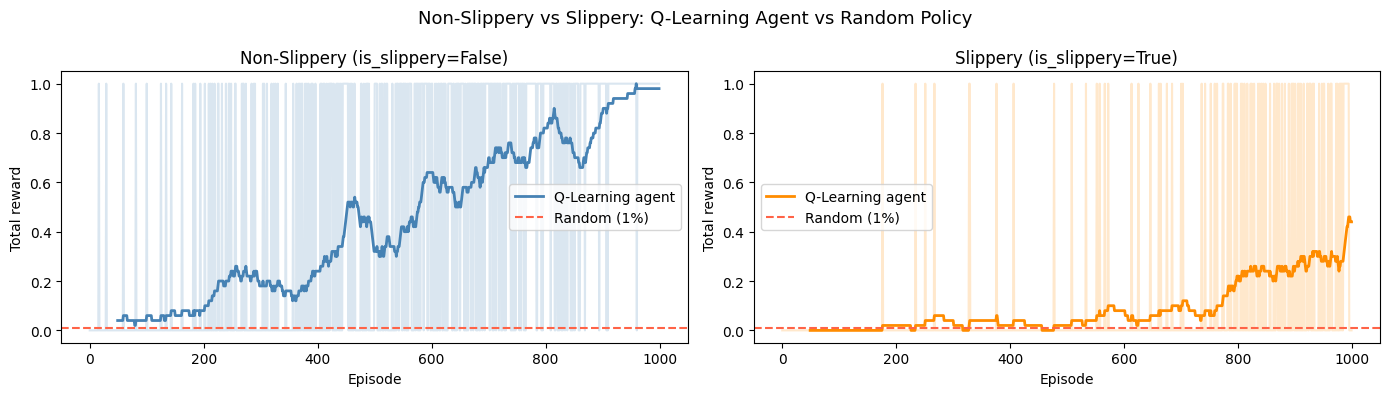

In [21]:
def random_policy_slippery(eval_episodes=100):
    env = gym.make("FrozenLake-v1", is_slippery=True)
    nb_success = 0
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            nb_success += reward
    env.close()
    return nb_success / eval_episodes * 100

def evaluate_agent_slippery(qtable, eval_episodes=100):
    env = gym.make("FrozenLake-v1", is_slippery=True)
    nb_success = 0
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(qtable[state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            nb_success += reward
    env.close()
    return nb_success / eval_episodes * 100

print("Training agent on slippery environment...")
qtable_slippery, rewards_slippery = train_agent(
    alpha=0.5, gamma=0.99, episodes=1000,
    epsilon=1.0, epsilon_decay=0.001, is_slippery=True
)

agent_slippery_avg  = evaluate_agent_slippery(qtable_slippery, eval_episodes=100)
random_slippery_avg = random_policy_slippery(eval_episodes=100)

print(f"Slippery agent  avg reward over 100 test episodes: {agent_slippery_avg:.1f}%")
print(f"Slippery random avg reward over 100 test episodes: {random_slippery_avg:.1f}%")
print(f"Improvement over random: +{agent_slippery_avg - random_slippery_avg:.1f}%")

# Plot comparison
smoothed_slip = rolling_avg(rewards_slippery, ROLLING_WIN)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Non-slippery
smoothed_base = rolling_avg(rewards_base, ROLLING_WIN)
axes[0].plot(range(len(rewards_base)), rewards_base, alpha=0.2, color="steelblue")
axes[0].plot(range(ROLLING_WIN - 1, len(rewards_base)), smoothed_base,
             color="steelblue", linewidth=2, label="Q-Learning agent")
axes[0].axhline(random_avg / 100, color="tomato", linestyle="--",
                label=f"Random ({random_avg:.0f}%)")
axes[0].set_title("Non-Slippery (is_slippery=False)")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Total reward")
axes[0].legend()

axes[1].plot(range(len(rewards_slippery)), rewards_slippery, alpha=0.2, color="darkorange")
axes[1].plot(range(ROLLING_WIN - 1, len(rewards_slippery)), smoothed_slip,
             color="darkorange", linewidth=2, label="Q-Learning agent")
axes[1].axhline(random_slippery_avg / 100, color="tomato", linestyle="--",
                label=f"Random ({random_slippery_avg:.0f}%)")
axes[1].set_title("Slippery (is_slippery=True)")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Total reward")
axes[1].legend()

plt.suptitle("Non-Slippery vs Slippery: Q-Learning Agent vs Random Policy", fontsize=13)
plt.tight_layout()
plt.savefig("slippery_comparison.png", dpi=150)
plt.show()